In [1]:
from bertopic import BERTopic
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# load data setof all countries, years and sources
data_file = '../data/all_countries_0.0.1.csv'
all_countries_data = pd.read_csv(data_file, dtype={'year': str}, comment='#')
# cast sentence column to string
all_countries_data['sentence'] = all_countries_data['sentence'].astype(str)

In [8]:
# check size of dataset
print(f"number of sentences: {len(all_countries_data)}.")
# check first entry
print(all_countries_data.iloc[0])

number of sentences: 325889.
sentence    The president is directly elected for up to tw...
section     ['Political Rights', 'Electoral Process', 'Was...
country                                                turkey
year                                                     2021
source                                           freedomhouse
Name: 0, dtype: object


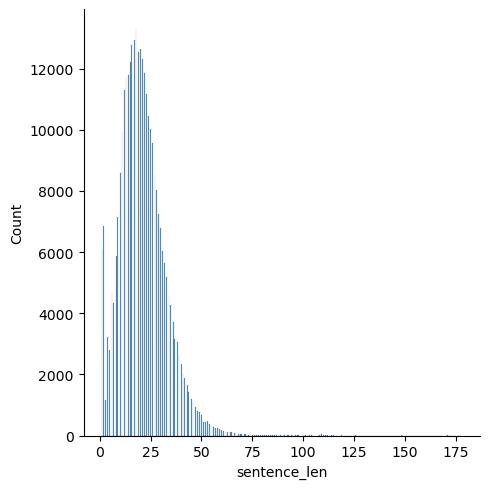

In [11]:
# calculate sentence lengths
all_countries_data["sentence_len"] = all_countries_data["sentence"].apply(lambda x: len(x.split()))
sns.displot(all_countries_data["sentence_len"], kde=False)

In [12]:
# choose a country and year
country = "hungary"
year = "2020"
df = pd.DataFrame(all_countries_data)
country_data = df[(df['year'] == year) & (df['country'] == country)]
# reset index; needed for proper parsing by BERT
country_data = country_data.reset_index(drop=True)

In [13]:
# show first 10 sentences
print(country_data.iloc[:10]['sentence'])

0    The National Assembly elects both the presiden...
1    The president’s duties are mainly ceremonial, ...
2    The president is limited to a maximum of two t...
3    János Áder, a founding member of Fidesz, has b...
4    Orbán has been prime minister since 2010, winn...
5    Voters elect representatives every four years ...
6    The coalition of Fidesz and its junior partner...
7    The far-right Movement for a Better Hungary (J...
8    An election-monitoring mission performed by th...
9    While there was no evidence of electoral fraud...
Name: sentence, dtype: object


In [25]:
# load BERT model paraphrase-MiniLM-L3-v2 (multilingual) or all-MiniLM-L6-v2 (english)
# setting min_topic_size to 7 and n_grams from 1 to 3
# we need to explore these parameters. Other parameters:
# https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html
# guided topic modeling: https://maartengr.github.io/BERTopic/getting_started/guided/guided.html
seed_topic_list = [["rule of law", "corruption"],
                   ["elections", "freedom"]]
model = BERTopic(seed_topic_list=seed_topic_list, verbose=True, embedding_model='all-MiniLM-L6-v2', min_topic_size = 10, n_gram_range=(1, 3))
# model = BERTopic(verbose=True, embedding_model='all-MiniLM-L6-v2', min_topic_size = 10, n_gram_range=(1, 3))
# fit model to our data
topics, _ = model.fit_transform(country_data.sentence)

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

2023-05-16 13:28:24,122 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-05-16 13:28:27,498 - BERTopic - Reduced dimensionality
2023-05-16 13:28:27,533 - BERTopic - Clustered reduced embeddings


In [26]:
# generate topic-document probability matrix
topic_distr, _ = model.approximate_distribution(country_data.sentence, min_similarity=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.84it/s]


In [27]:
# get topic information
freq = model.get_topic_info()
# print topic information
print(f"Number of topics: {len(freq)}")
print(freq.head())

Number of topics: 54
   Topic  Count                                     Name
0     -1    553                          -1_the_of_in_to
1      0    120                      0_fidesz_the_to_and
2      1     89          1_corruption_of_the_prosecution
3      2     87          2_media_the media_the_pluralism
4      3     68  3_freedom_freedom of_the_the freedom of


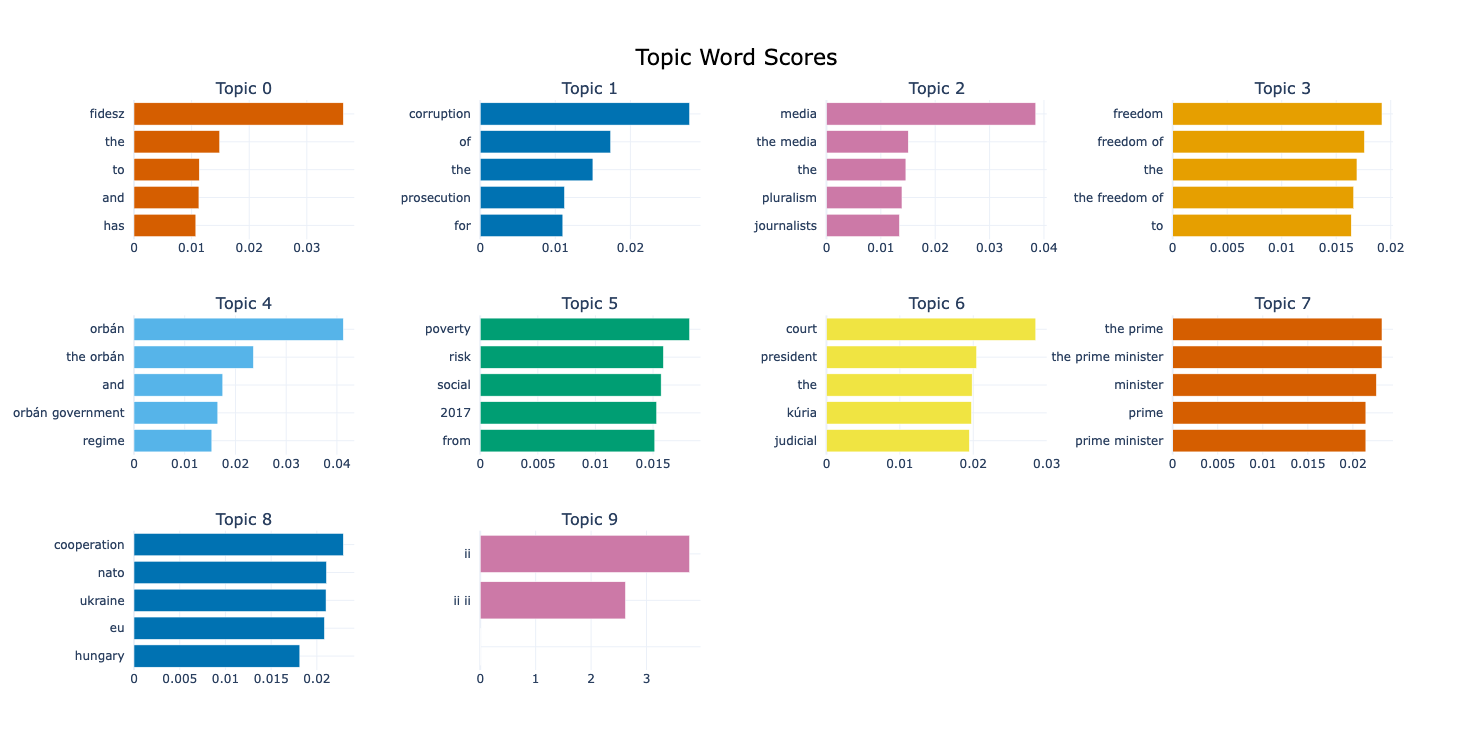

In [28]:
# visualize topic words/n_grams
model.visualize_barchart(top_n_topics=10)

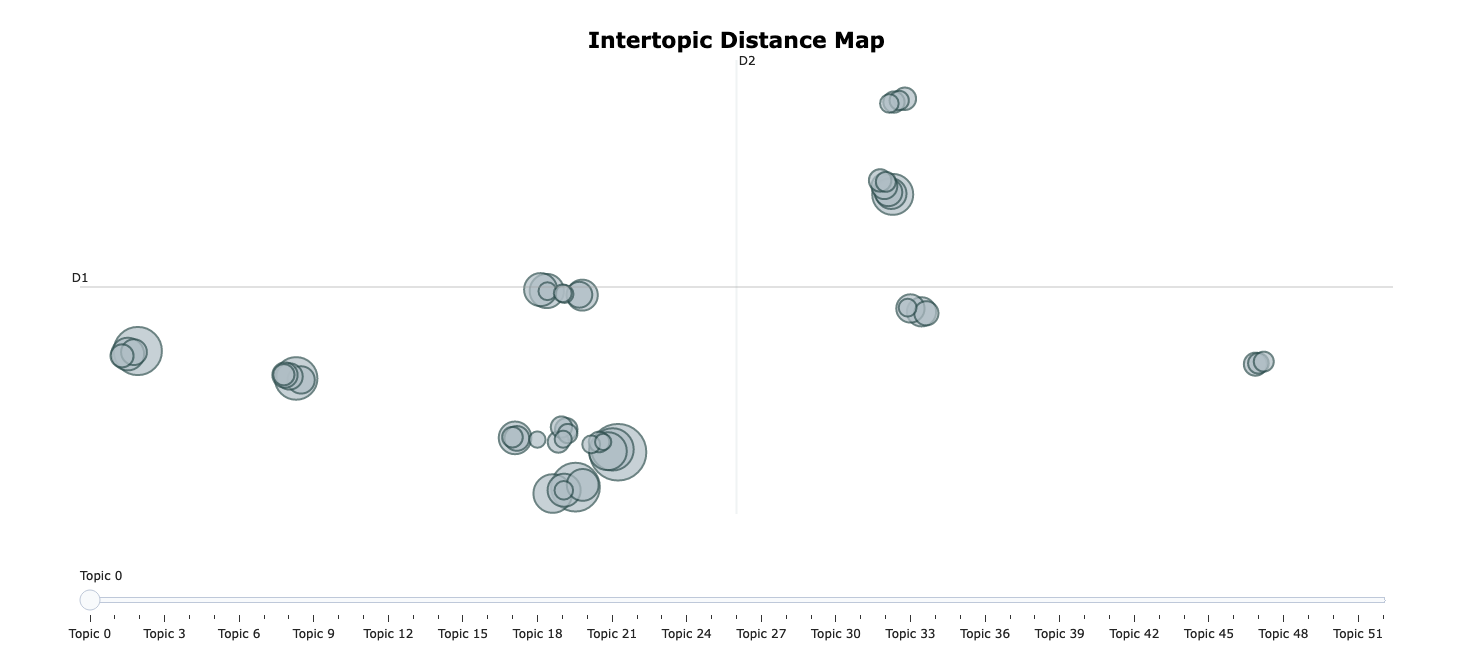

In [29]:
model.visualize_topics()

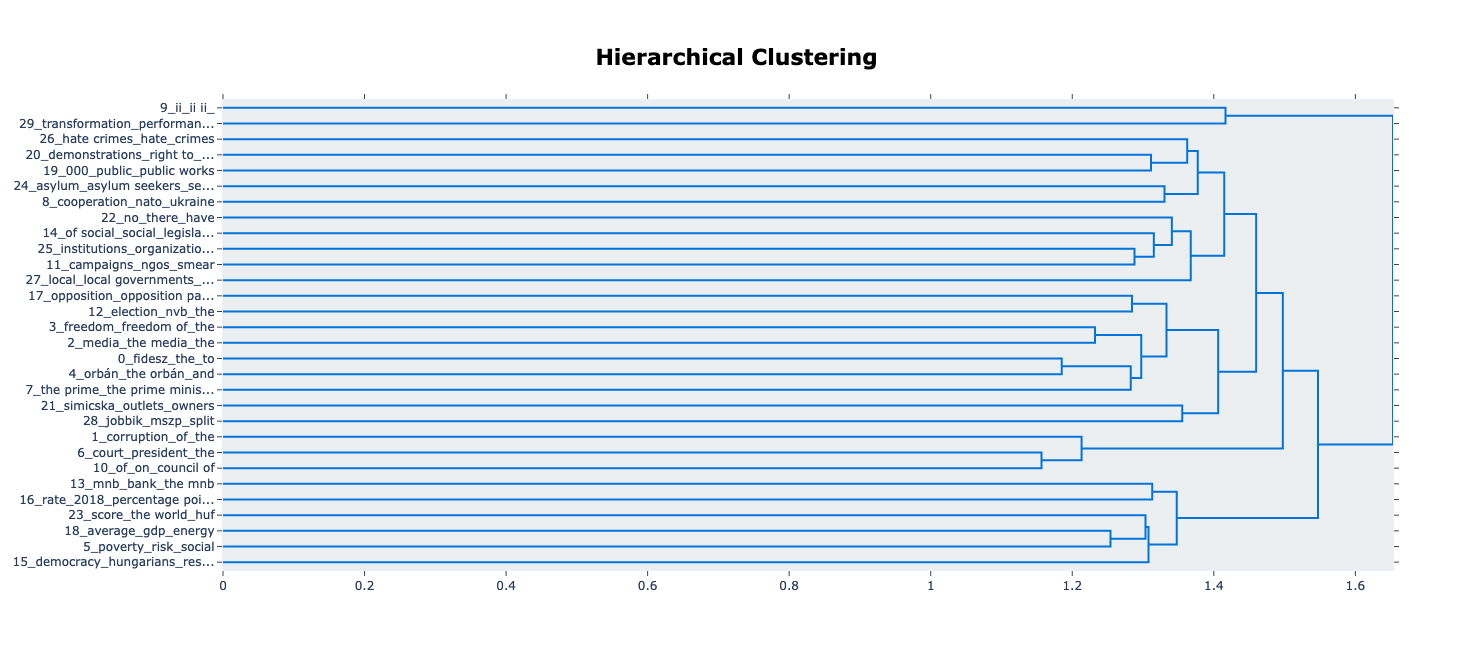

In [30]:
# visualize topic clusters
model.visualize_hierarchy(top_n_topics=30)

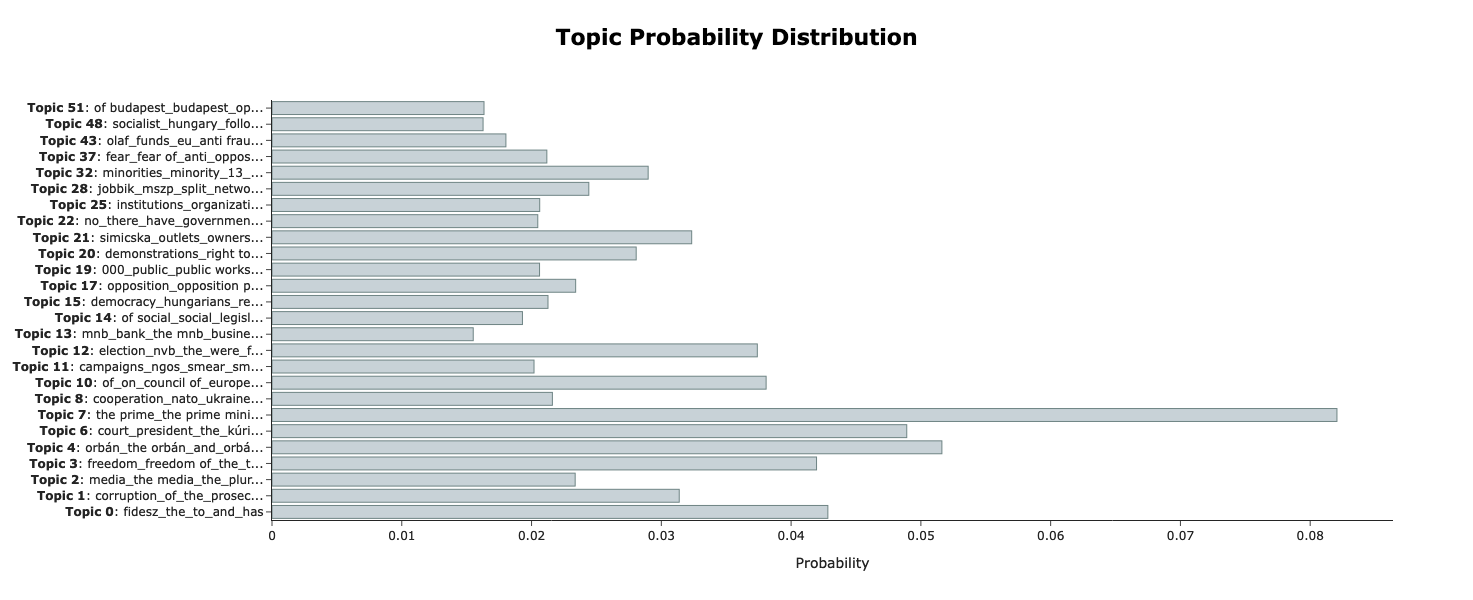

In [31]:
model.visualize_distribution(topic_distr[0])

In [46]:
# search for similar topics
topics = ["freedom", "rule of law", "liberty", "journalism"]
for topic in topics:
    similar_topics, similarities = model.find_topics(topic, top_n = 1)
    # most_similar = similar_topics[0]
    print(f"---{topic.upper()}---")
    for most_similar, similarity in zip(similar_topics, similarities):
        print(f"Most Similar Topic Info: {model.get_topic(most_similar)}")
        print(f"Most Similar Topic Number: {most_similar}")
        print(f"Similarity Score: {similarity}")


---FREEDOM---
Most Similar Topic Info: [('freedom', 0.019198794463432072), ('freedom of', 0.01758590682667371), ('the', 0.016903039162402884), ('the freedom of', 0.016596780906956383), ('to', 0.016380416155307834), ('the freedom', 0.01621531588296137), ('assembly', 0.0158482937650328), ('information', 0.014776266604687106), ('the government', 0.012879236459671114), ('the constitution', 0.012737485614748119)]
Most Similar Topic Number: 3
Similarity Score: 0.8782960813823527
---RULE OF LAW---
Most Similar Topic Info: [('private', 0.0547232898823548), ('private interests', 0.03527930064729101), ('interests', 0.030290576897094093), ('the ruling party', 0.027743395674109828), ('the ruling', 0.02716351457375865), ('ruling party', 0.02716351457375865), ('economic', 0.02672234492173627), ('ruling', 0.026021009225517484), ('sectors', 0.025666413952369224), ('governing elite and', 0.025088110924928863)]
Most Similar Topic Number: 34
Similarity Score: 0.5161417168106799
---LIBERTY---
Most Similar

In [33]:
# save model
model.save(f"../data/{country}_{year}")

# loading model
# model=BERTopic.load("../data/file")